<a href="https://colab.research.google.com/github/MUbarak123-56/aurelion-geron-tensorflow/blob/master/chapter3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame = False)

In [48]:
X, y = mnist.data, mnist.target

In [49]:
X[:10,:]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [50]:
y[:10]

array(['5', '0', '4', '1', '9', '2', '1', '3', '1', '4'], dtype=object)

In [51]:
X.shape

(70000, 784)

In [52]:
y.shape

(70000,)

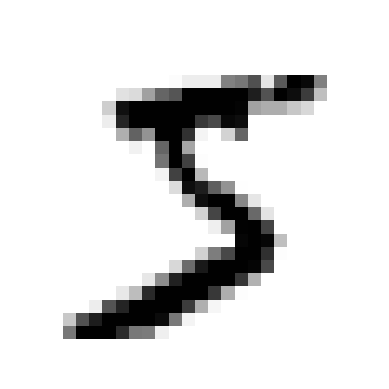

In [53]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
  image = image_data.reshape(28,28)
  plt.imshow(image, cmap="binary")
  plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [54]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Training a Binary Classifier

In [55]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [56]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42) ## explicitly set hyper parameters
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [57]:
sgd_clf.predict([some_digit])

array([ True])

In [58]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy") ## prints out cross validated results

array([0.95035, 0.96035, 0.9604 ])

In [59]:
### Test with Dummy Classifier to compare performance with predicting everything as non-5

from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [60]:
## writing code that does the same as cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3) ## add shuffle = True if dataset is not shuffled

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)

  print(n_correct/len(y_pred))

0.95035
0.96035
0.9604


### Confusion Matrices

In [61]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [62]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

In [63]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [64]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [65]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [66]:
f1_score(y_train_5, y_train_pred)

0.7325171197343847

### The Precision/Recall Trade-Off

We can rely on a threshold to decide whether each observation belongs to a specific group or not.

In [67]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [68]:
threshold = 0

y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [69]:
threshold = 3000

y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [72]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method="decision_function")

In [73]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

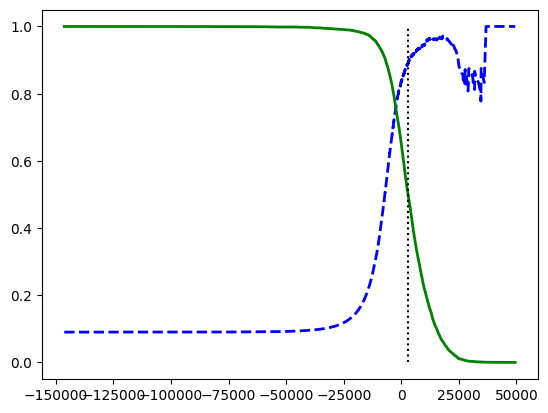

In [74]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
# beautify the figure: add grid, legend, axis, labels, and circles
plt.show()

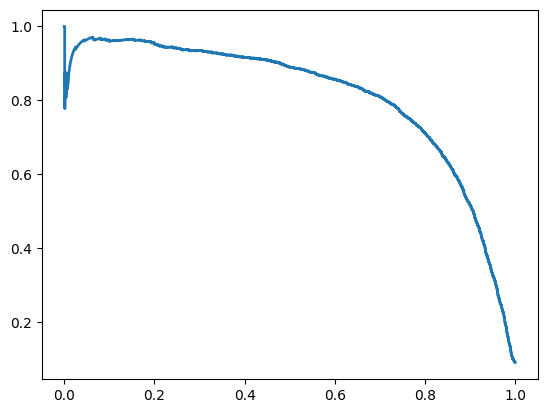

In [75]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.show()

In [78]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.0194991439557)

In [79]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [80]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [81]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

### The ROC Curve

In [82]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

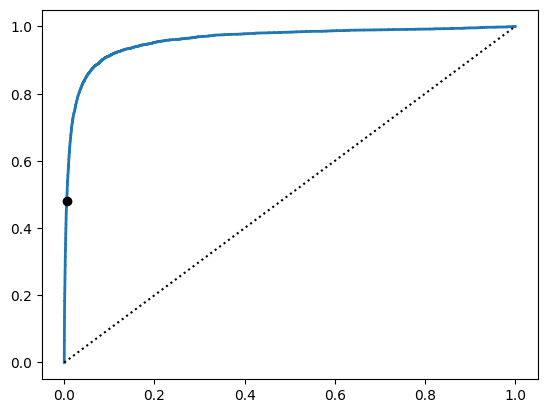

In [83]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
plt.show()

In [84]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

In [85]:
from sklearn.ensemble import RandomForestClassifier

In [89]:
forest_clf = RandomForestClassifier(random_state = 42)

In [90]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method="predict_proba")

In [91]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [92]:
y_scores_forest = y_probas_forest[:,1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

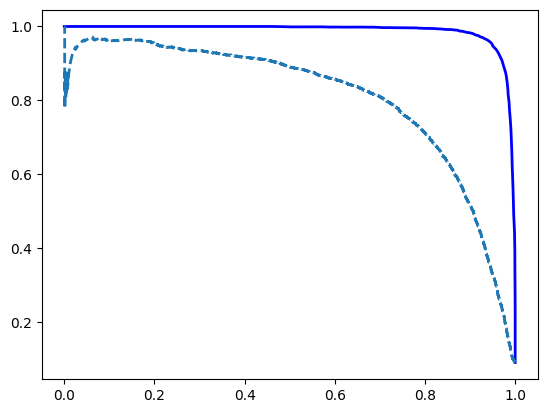

In [93]:
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.show()

In [94]:
y_train_pred_forest = y_probas_forest[:,1] >= 0.5
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [95]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983436731328145)

### Multiclass Classification

There are two approaches: One vs Rest or One vs One. One vs Rest takes each class and compares it to the remaining classes. Therefore, needing N classifiers in the case of having N elements. One vs One compares each class to another class and uses N(N-1)/2 classifiers.

In [96]:
from sklearn.svm import SVC

svm_clf = SVC(random_state = 42)
svm_clf.fit(X_train[:2000], y_train[:2000]) ## when doing multiclass classification, SVC uses One v One method to build N(N-1)/2 classifiers for prediction.

SVC(random_state=42)

In [97]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [98]:
some_digit_scores = svm_clf.decision_function([some_digit])

some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [99]:
class_id = some_digit_scores.argmax()
class_id

np.int64(5)

In [100]:
svm_clf.classes_[class_id]

'5'

In [101]:
## in order to force the usage of One Vs Rest or One vs One, we can import the module from scikit-learn

from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000],y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [102]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [103]:
len(ovr_clf.estimators_)

10

In [104]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit]) ## some digit is 5 so anything other than that is wrong

array(['3'], dtype='<U1')

In [105]:
sgd_clf.decision_function([some_digit]).round() ## it can be observed that 3 has the highest decision function score

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [106]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [107]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

### Error Analysis

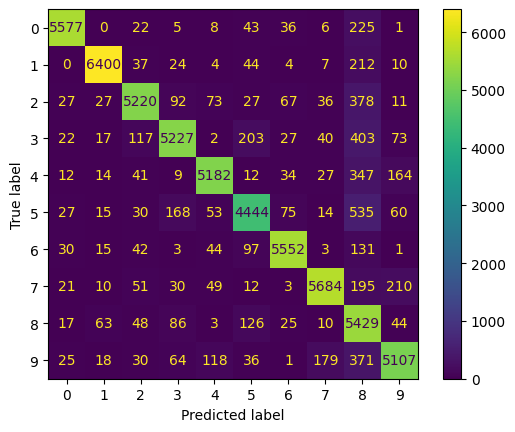

In [109]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

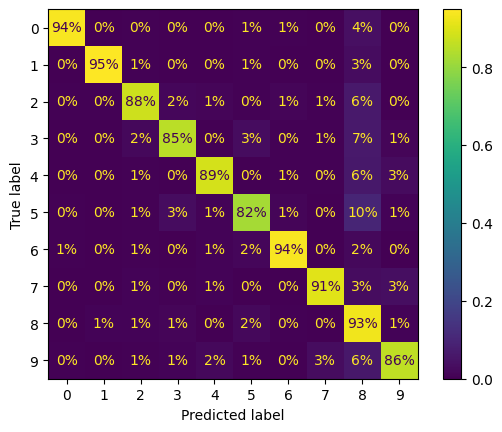

In [110]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", values_format=".0%") ## it is advisable to normalize the confusion matrix as there could be class imbalance
plt.show()

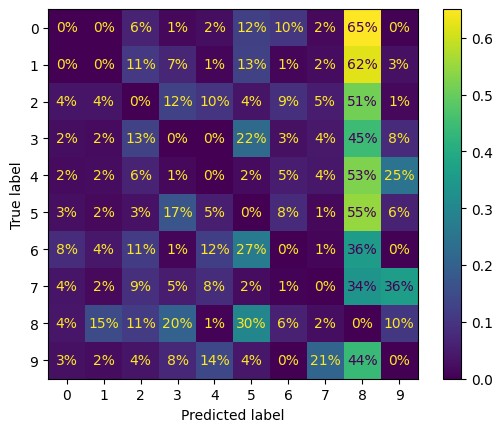

In [111]:
## confusion matrix without correct predictions
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
plt.show()

### Multilabel Classification

In [112]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [113]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [114]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

In [115]:
from sklearn.multioutput import ClassifierChain ## classifierchain can be used to support models that do not natively support Multilabel Classification

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [116]:
chain_clf.predict([some_digit])

array([[0., 1.]])

### Multioutput Classification

In this case, we have multiple labels that we are trying to predict. Think of a situation like image reconstruction, we might be interested in determining the level of intensity of each pixel. Therefore, we have a high number of input variables as well as output variables.

In [ ]:
np.random.seed(42)  # to make this code example reproducible
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()